# General Analysis plots for a cosmological simulation with halo data already extracted. 

In [141]:
%load_ext autoreload
%autoreload 1

import yt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from HaloData import *

dataset_fname  = "test_data/RD0009/RD0009"
halo_dat_fname = "test_data/halo_test.dat"
halo_dat2_fname = "test_data/halo_test_many_halos.dat"

hd_small = HaloData.load_from_file(halo_dat_fname)
hd = HaloData.load_from_file(halo_dat2_fname)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
def DarkMatter(pfilter, data):
    filter = data[("all", "particle_type")] == 1 # DM = 1, Stars = 2
    return filter
    
yt.add_particle_filter("dark_matter", function=DarkMatter, filtered_type='all', \
                    requires=["particle_type"])

def stars(pfilter, data):
    filter = data[("all", "particle_type")] == 2 # DM = 1, Stars = 2
    return filter

yt.add_particle_filter("stars", function=stars, filtered_type='all', \
                       requires=["particle_type"])

ds = yt.load(dataset_fname)
ds.add_particle_filter('stars')
ds.add_particle_filter('dark_matter')
ad = ds.all_data()
(ad.right_edge-ad.left_edge).to('Mpc')

yt : [INFO     ] 2020-05-07 18:05:57,649 Parameters: current_time              = 228.09678799281
yt : [INFO     ] 2020-05-07 18:05:57,650 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-05-07 18:05:57,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-07 18:05:57,651 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-05-07 18:05:57,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-07 18:05:57,652 Parameters: current_redshift          = 0.006999007368208
yt : [INFO     ] 2020-05-07 18:05:57,652 Parameters: omega_lambda              = 0.732
yt : [INFO     ] 2020-05-07 18:05:57,652 Parameters: omega_matter              = 0.268
yt : [INFO     ] 2020-05-07 18:05:57,652 Parameters: hubble_constant           = 0.704
Parsing Hierarchy : 100%|██████████| 182/182 [00:00<00:00, 38518.69it/s]
yt : [INFO     ] 2020-05-07 18:05:57,665 Gathering a field list (this may take a moment.)


YTArray([45.13861992, 45.13861992, 45.13861992]) Mpc

# Stellar Mass Fraction for 25 Mpc Box at z = 0

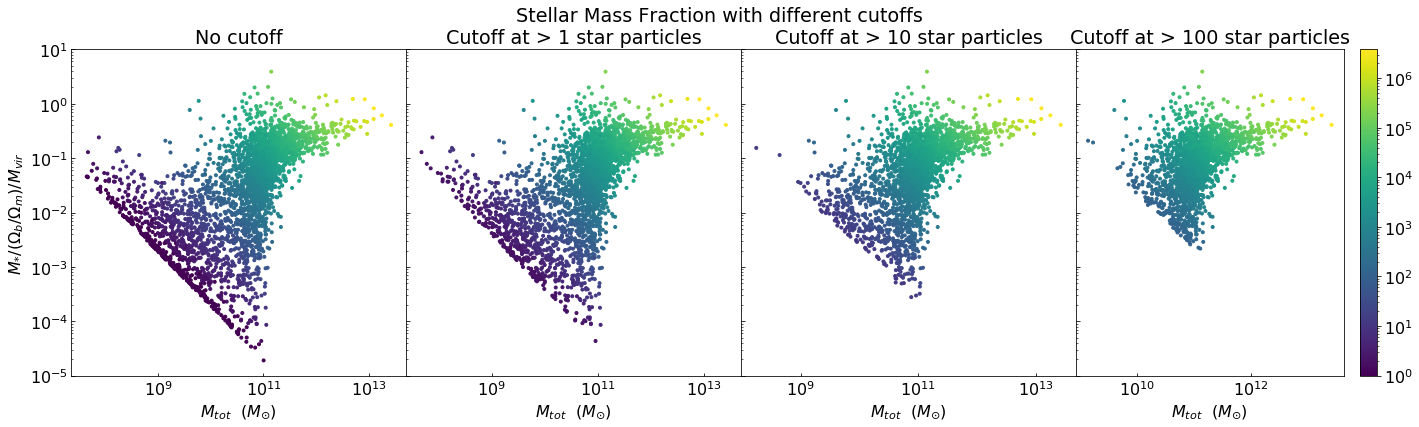

In [22]:
%aimport plots
%aimport HaloData
from plots import *
#stellar_mass_fraction_scatter(halo_dat2_fname, cutoff=0)
stellar_mass_fraction_scatter_multi(hd)
#interact(stellar_mass_fraction_scatter, hd=fixed(hd), cutoff=(0, 1e3));

# Too many stars?
Not sure why some halos have a stellar mass fraction greater than 1. It might be a dataset mismatch. It's hard to keep track of which halo catalogs belong to which Enzo dataset. I need to try to figure out some way to keep track of which datasets correspond to which halo catalogs. 

If it's a dataset mismatch, why are there clear trends to be seen in the graphs? You'd expect it to be basically random.

# Data Resolution
It should make sense that the star particle cutoff results in clean, diagonal cuts on the left side of the graph. It might help to plot the stellar mass vs halo mass with number of star particles as well next to this graph just to help me make sense of things. It might be worth looking into doing a vertical cut at ~$10^{10}$ stellar masses. The justification for this being that the mass resolution for these halos is low, thus the data are less trustworthy. Need to confirm this and come up with a formula to determine a proper cutoff mass. 



# Formula used to calculate stellar mass fraction:
$$
f = \frac{M_*}{\displaystyle \frac{\Omega_b}{\Omega_m} M_h}
$$

where
$M_*$ is total stellar mass in a halo

$\Omega_b$ is the cosmological baryon fraction

$\Omega_c$ is the cosmological (cold) dark matter fraction

$\Omega_m = \Omega_b + \Omega_c$

$M_h$ is the halo mass. Note: make sure we calculate halo mass the same way Behroozi does in Behroozi et al (2013)


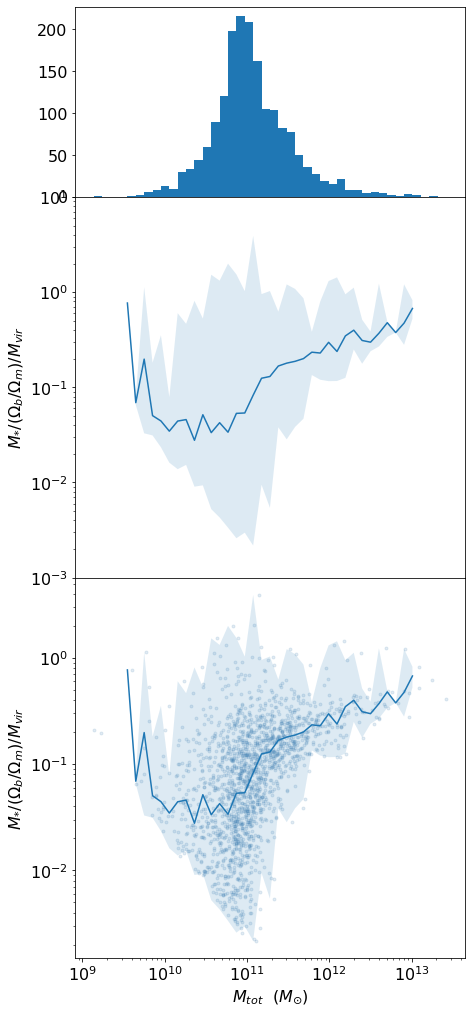

In [174]:
# Placeholder for Histogram Code
%aimport plots
from plots import *
cut = 100
#halo_mass_histogram(hd, cutoff=cut)
stellar_mass_fraction_reduced(hd, cutoff=cut)

Top: The histogram of all halos binned by halo mass using $\sqrt{N}$ bins where $N$ is the number of halos. 

Middle: The solid line shows the median stellar mass fraction in each bin. The shaded region is the fill between the maximum and minimum values in each bin. 

Bottom: Same as the middle, except with all the halos plotted over. 

yt : [INFO     ] 2020-05-07 18:20:16,239 Projection completed
yt : [INFO     ] 2020-05-07 18:20:16,239 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,240 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,240 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,241 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,241 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-07 18:20:16,374 Projection completed
yt : [INFO     ] 2020-05-07 18:20:16,374 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,375 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,375 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,376 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:20:16,377 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800


Annotating halos...


100%|██████████| 45/45 [00:00<00:00, 79370.77it/s]



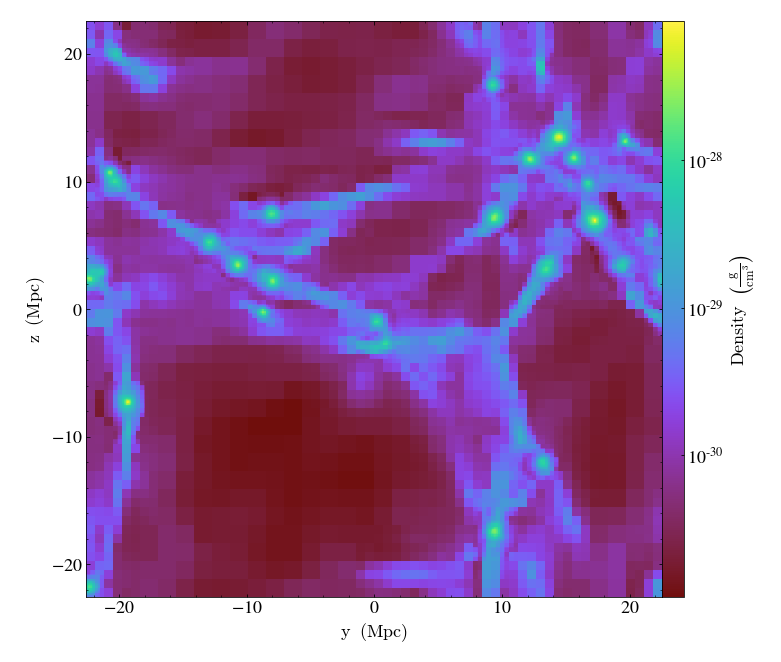


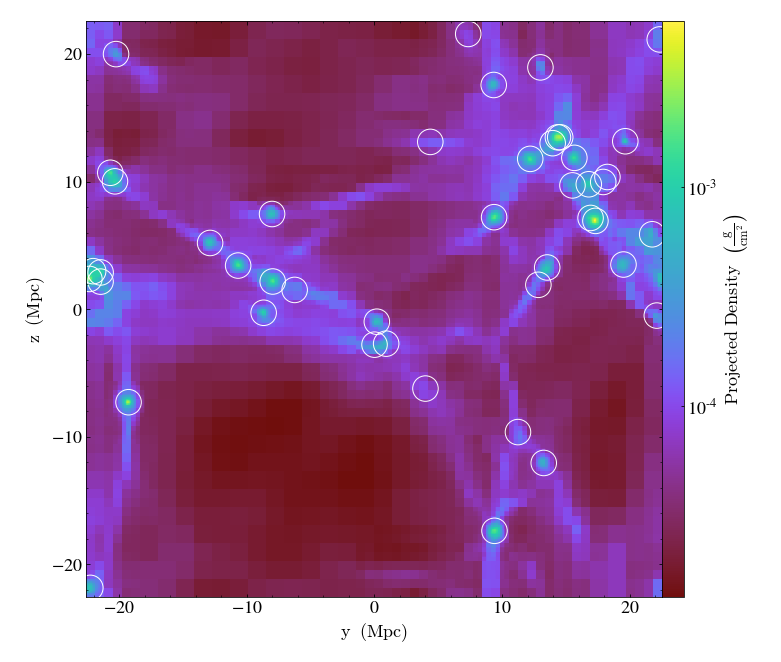

In [190]:
%aimport plots
from plots import *
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='temperature')
hal = projection_w_halos(ds,hd_small, 'density')

p.show()
hal.show()

yt : [INFO     ] 2020-05-07 18:19:07,272 Projection completed
yt : [INFO     ] 2020-05-07 18:19:07,273 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,273 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,274 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,274 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,278 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-07 18:19:07,413 Projection completed
yt : [INFO     ] 2020-05-07 18:19:07,413 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,414 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,415 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,415 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:19:07,416 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



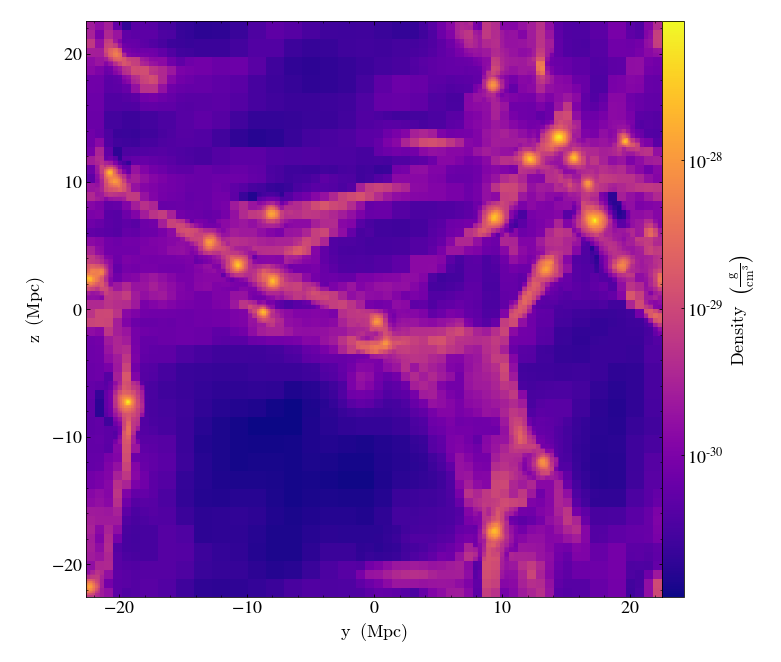


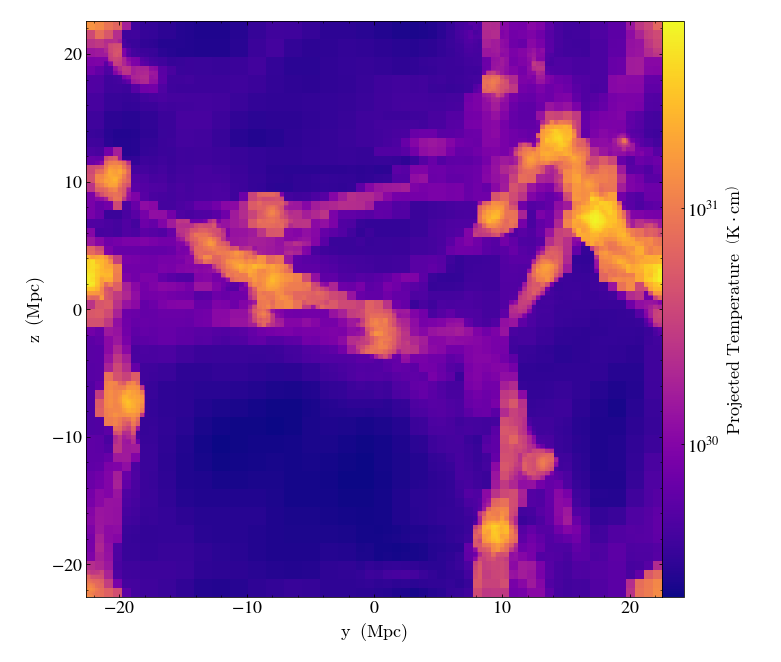

In [188]:
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='temperature')
p.set_cmap('density', cmap='plasma')
temp = yt.ProjectionPlot(ds, 'x', "temperature")
temp.set_cmap('temperature', cmap='plasma')

p.show()
temp.show()

yt : [INFO     ] 2020-05-07 18:17:42,756 Projection completed
yt : [INFO     ] 2020-05-07 18:17:42,756 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,757 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,757 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,758 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,759 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2020-05-07 18:17:42,915 Projection completed
yt : [INFO     ] 2020-05-07 18:17:42,916 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,916 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,917 xlim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,917 ylim = 0.000000 1.000000
yt : [INFO     ] 2020-05-07 18:17:42,918 Making a fixed resolution buffer of (('gas', 'metallicity')) 800 by 800



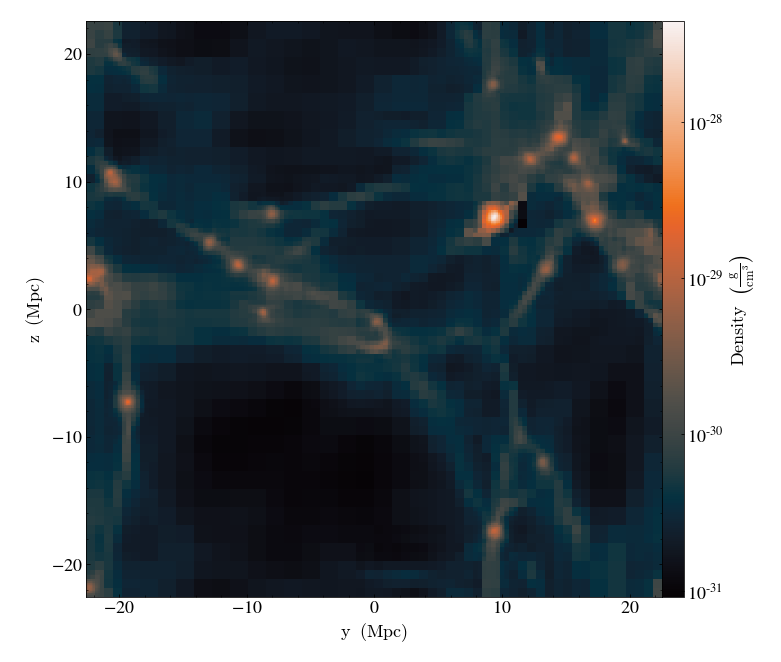


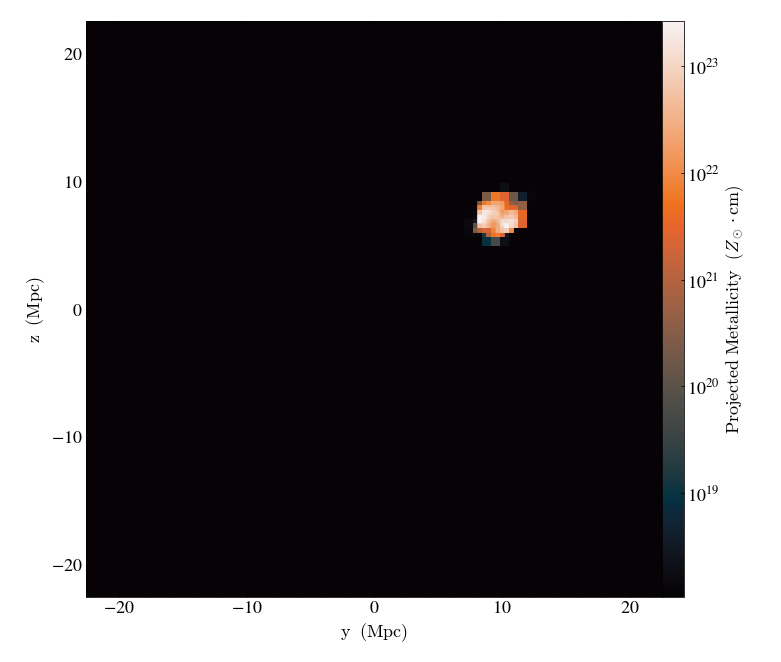

In [186]:
%aimport plots
from plots import *
p = yt.ProjectionPlot(ds, 'x', "density", weight_field='metallicity')
p.set_cmap('density', cmap='dusk')
metal = yt.ProjectionPlot(ds, 'x', "metallicity")
metal.set_cmap('metallicity', cmap='dusk')

p.show()
metal.show()


Metallicity is set to a small ($\sim10^{-20}$) value in the initial conditions, which is why the metallicity around non-star forming regions is not zero. Since the value is the same everywhere, it represents the same fractional value of the density. So weighting by metallicty in regions that are not star-forming is effectively identical to weighting by density. 